In [101]:
import os
import pandas as pd
import torch
import torch.profiler as profiler
from torch.profiler import ProfilerActivity, profile, record_function
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from torch.optim import AdamW
import wandb
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np
from sklearn.model_selection import train_test_split

In [102]:
print("All imports successful")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

All imports successful
PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4

Using device: cuda


In [103]:
from google.colab import files
# uploaded = files.upload()
# phrasebank_file = list(uploaded.keys())[0]
phrasebank_file = "FinancialPhraseBank-v1.0/Sentences_50Agree.txt"
print(f"Uploaded: {phrasebank_file}")

Saving Sentences_50Agree.txt to Sentences_50Agree (3).txt


In [106]:
print("\nParsing dataset...")
sentences = []
labels = []

with open(phrasebank_file, 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        line = line.strip()
        if '@' not in line:
            continue

        parts = line.rsplit('@', 1)
        if len(parts) != 2:
            continue

        sentence, sentiment = parts
        sentence = sentence.strip()
        sentiment = sentiment.strip().lower()

        if sentiment in ['positive', 'negative', 'neutral']:
            sentences.append(sentence)
            labels.append(sentiment)

print(f"Parsed {len(sentences)} sentences")


Parsing dataset...
Parsed 4846 sentences


In [107]:
df = pd.DataFrame({
    'sentence': sentences,
    'sentiment': labels
})

In [108]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_map)

In [109]:
print("\nLabel distribution:")
print(df['sentiment'].value_counts())
print("\nSample data:")
print(df.head())



Label distribution:
sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

Sample data:
                                            sentence sentiment  label
0  According to Gran , the company has no plans t...   neutral      1
1  Technopolis plans to develop in stages an area...   neutral      1
2  The international electronic industry company ...  negative      0
3  With the new production plant the company woul...  positive      2
4  According to the company 's updated strategy f...  positive      2


In [110]:
print("Creating train/validation/test splits...")

# 80/10/10 split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Save to CSV
os.makedirs("data/sentiment_data", exist_ok=True)
train_df.to_csv("data/sentiment_data/train.csv", index=False)
val_df.to_csv("data/sentiment_data/validation.csv", index=False)
test_df.to_csv("data/sentiment_data/test.csv", index=False)
print("Saved CSV files to data/sentiment_data/")

Creating train/validation/test splits...
Train: 3876 samples
Validation: 485 samples
Test: 485 samples
Saved CSV files to data/sentiment_data/


In [111]:
print("Loading FinBERT model...")

model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded on {device}")
print(f"Number of labels: {model.config.num_labels}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading FinBERT model...
✓ Model loaded on cuda
Number of labels: 3
Model parameters: 109,754,115


In [112]:
print("Creating datasets...")

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['sentence', 'label']])
val_dataset = Dataset.from_pandas(val_df[['sentence', 'label']])
test_dataset = Dataset.from_pandas(test_df[['sentence', 'label']])


Creating datasets...


In [113]:
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        truncation=True,
        max_length=64,
        padding=False
    )

In [114]:
# Tokenize datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True, remove_columns=["sentence"])
val_tokenized = val_dataset.map(tokenize_function, batched=True, remove_columns=["sentence"])
test_tokenized = test_dataset.map(tokenize_function, batched=True, remove_columns=["sentence"])

train_tokenized.set_format("torch")
val_tokenized.set_format("torch")
test_tokenized.set_format("torch")

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [115]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch])

    input_ids_padded = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=tokenizer.pad_token_id
    )
    attention_mask_padded = torch.nn.utils.rnn.pad_sequence(
        attention_mask, batch_first=True, padding_value=0
    )

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels
    }

In [116]:
# Create dataloaders
batch_size = 16

train_loader = DataLoader(
    train_tokenized,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_tokenized,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

In [117]:
inference_dataset = test_tokenized.select(range(min(100, len(test_tokenized))))
inference_loader = DataLoader(
    inference_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0  # Single-threaded for inference
)

In [118]:
print(f"DataLoaders created")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Inference batches: {len(inference_loader)}")

DataLoaders created
Training batches: 243
Validation batches: 31
Inference batches: 7


In [119]:
# Login to W&B
!wandb login

# Initialize run
wandb.init(
    project="finbert-profiling",
    name="training-inference-profile",
    config={
        "model": model_name,
        "batch_size": batch_size,
        "max_length": 64,
        "device": str(device)
    }
)

wandb: Currently logged in as: iyer-shobini (iyer-shobini-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


BASELINE TIMING

Measuring baseline performance...


Training:   0%|          | 0/243 [00:00<?, ?it/s]

Inference:   0%|          | 0/7 [00:00<?, ?it/s]


Baseline Results:
  Training (20 batches): 4.02s (201.1ms/batch)
  Training loss: 3.8489
  Inference: 0.33s (47.4ms/batch)


In [121]:
print("\n" + "="*60)
print("TRAINING PROFILING")
print("="*60)

# Reinitialize model for clean profiling
model = BertForSequenceClassification.from_pretrained(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader)*2)

# Warmup
print("Warmup...")
warmup_batch = next(iter(train_loader))
warmup_batch = {k: v.to(device) for k, v in warmup_batch.items()}
optimizer.zero_grad()
model(**warmup_batch).loss.backward()
optimizer.step()

print("Starting profiler...")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU],
    record_shapes=True,
    profile_memory=True,
    with_flops=True
) as prof:
    model.train()

    for i, batch in enumerate(train_loader):
        if i >= 20:  # Profile 20 batches
            break

        batch = {k: v.to(device) for k, v in batch.items()}

        with record_function("forward_backward"):
            optimizer.zero_grad()
            loss = model(**batch).loss
            loss.backward()

        with record_function("optimizer_step"):
            optimizer.step()
            scheduler.step()

        if torch.cuda.is_available():
            torch.cuda.synchronize()

# Export trace
prof.export_chrome_trace("finbert_training_trace.json")
print("Saved: finbert_training_trace.json")

# Print top operations
print("\nTop Training Operations (CPU):")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=15))

if torch.cuda.is_available():
    print("\nTop Training Operations (CUDA):")
    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=15))



TRAINING PROFILING
Warmup...
Starting profiler...
Saved: finbert_training_trace.json

Top Training Operations (CPU):
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaDeviceSynchronize        47.08%       

In [122]:
print("\n" + "="*60)
print("INFERENCE PROFILING")
print("="*60)

# Warmup
model.eval()
with torch.no_grad():
    warmup_batch = next(iter(inference_loader))
    _ = model(**{k: v.to(device) for k, v in warmup_batch.items()})

print("Starting inference profiler...")

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU],
    record_shapes=True,
    profile_memory=True,
    with_flops=True
) as prof_inf:
    model.eval()

    with torch.no_grad():
        for batch in inference_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            with record_function("inference"):
                _ = model(**batch)

            if torch.cuda.is_available():
                torch.cuda.synchronize()

# Export trace
prof_inf.export_chrome_trace("finbert_inference_trace.json")
print("Saved: finbert_inference_trace.json")

# Print top operations
print("\nTop Inference Operations (CPU):")
print(prof_inf.key_averages().table(sort_by="cpu_time_total", row_limit=15))

if torch.cuda.is_available():
    print("\nTop Inference Operations (CUDA):")
    print(prof_inf.key_averages().table(sort_by="cuda_time_total", row_limit=15))



INFERENCE PROFILING
Starting inference profiler...
Saved: finbert_inference_trace.json

Top Inference Operations (CPU):
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaDeviceSynchronize        51.15%    


ANALYSIS & VISUALIZATION

Top 10 Training Operations:
                                          Operation  CPU Time (ms)  CUDA Time (ms)
                              cudaDeviceSynchronize    1992.449804             0.0
                                   forward_backward    1341.210485             0.0
autograd::engine::evaluate_function: AddmmBackward0     283.390091             0.0
                                     optimizer_step     196.898624             0.0
                          Optimizer.step#AdamW.step     194.195337             0.0
                                     AddmmBackward0     194.078471             0.0
                                       aten::linear     178.259264             0.0
                                   cudaLaunchKernel     139.187737             0.0
                                           aten::mm     128.122275             0.0
                                        aten::addmm     112.575325             0.0

Top 10 Inference Operations:
  

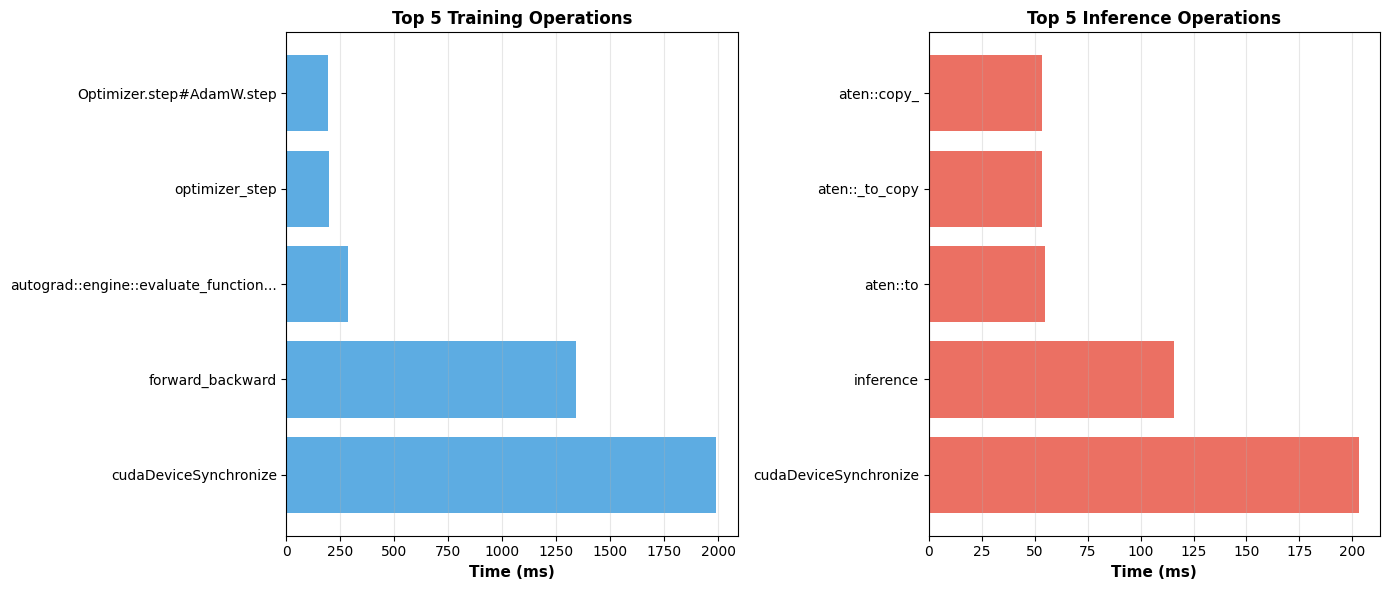

In [123]:
print("\n" + "="*60)
print("ANALYSIS & VISUALIZATION")
print("="*60)

# Extract top operations
def extract_top_ops(prof, mode_name, top_n=10):
    ops_data = []
    for evt in prof.key_averages():
        ops_data.append({
            "Mode": mode_name,
            "Operation": evt.key,
            "CPU Time (ms)": evt.cpu_time_total / 1000,
            "CUDA Time (ms)": getattr(evt, "cuda_time_total", 0) / 1000,
            "Calls": evt.count
        })
    df = pd.DataFrame(ops_data)
    return df.sort_values("CPU Time (ms)", ascending=False).head(top_n)

train_ops = extract_top_ops(prof, "Training")
inf_ops = extract_top_ops(prof_inf, "Inference")

print("\nTop 10 Training Operations:")
print(train_ops[["Operation", "CPU Time (ms)", "CUDA Time (ms)"]].to_string(index=False))

print("\nTop 10 Inference Operations:")
print(inf_ops[["Operation", "CPU Time (ms)", "CUDA Time (ms)"]].to_string(index=False))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training ops
train_top5 = train_ops.head(5)
y_pos = np.arange(len(train_top5))
ax1.barh(y_pos, train_top5["CPU Time (ms)"], color='#3498db', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([op[:35] + "..." if len(op) > 35 else op for op in train_top5["Operation"]])
ax1.set_xlabel("Time (ms)", fontsize=11, fontweight='bold')
ax1.set_title("Top 5 Training Operations", fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Inference ops
inf_top5 = inf_ops.head(5)
y_pos = np.arange(len(inf_top5))
ax2.barh(y_pos, inf_top5["CPU Time (ms)"], color='#e74c3c', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([op[:35] + "..." if len(op) > 35 else op for op in inf_top5["Operation"]])
ax2.set_xlabel("Time (ms)", fontsize=11, fontweight='bold')
ax2.set_title("Top 5 Inference Operations", fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig("finbert_profiling.png", dpi=150, bbox_inches='tight')
wandb.log({"profiling_visualization": wandb.Image(fig)})
plt.show()

# Log to W&B
wandb.log({
    "training_operations": wandb.Table(dataframe=train_ops),
    "inference_operations": wandb.Table(dataframe=inf_ops)
})

In [124]:
print("\n" + "="*60)
print("BOTTLENECK ANALYSIS & RECOMMENDATIONS")
print("="*60)

# Identify dominant operations
train_dominant = train_ops.iloc[0]
inf_dominant = inf_ops.iloc[0]

print(f"\nDominant Training Operation:")
print(f"  {train_dominant['Operation']}")
print(f"  Time: {train_dominant['CPU Time (ms)']:.2f}ms")
print(f"  {train_dominant['CPU Time (ms)']/train_ops['CPU Time (ms)'].sum()*100:.1f}% of profiled time")

print(f"\nDominant Inference Operation:")
print(f"  {inf_dominant['Operation']}")
print(f"  Time: {inf_dominant['CPU Time (ms)']:.2f}ms")
print(f"  {inf_dominant['CPU Time (ms)']/inf_ops['CPU Time (ms)'].sum()*100:.1f}% of profiled time")



BOTTLENECK ANALYSIS & RECOMMENDATIONS

Dominant Training Operation:
  cudaDeviceSynchronize
  Time: 1992.45ms
  41.9% of profiled time

Dominant Inference Operation:
  cudaDeviceSynchronize
  Time: 202.85ms
  31.9% of profiled time
